# TDA on Proteins

## Installation required for Colab

In [ ]:
!pip install nglview
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.3/380.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.9 MB/s eta 0:00:00


## Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import copy
from IPython import display

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

from google.colab import drive
drive.mount('/content/drive')

import os
import nglview as nv
from Bio import PDB

Mounted at /content/drive


## Auxiliar functions

In [ ]:
def binary_search(element, ordered_list):
    '''
    Given an element and an ordered list this algorithm finds the index such that:
    ordered_list[i-1] < element <= ordered_list[i]
    If the element is bigger then every other the it returns the lenght of the list
    If the element is lower then every other it returns 0

    Input:
    - element: a floating point number
    - ordered_list: an increasing ordered list

    Output:
    The index i such that:
    i = 0 when element <= ordered_list[0]
    i = len(ordered_list) when element > ordered_list[-1]
    elsewhere the index is such that ordered_list[i-1] < element <= ordered_list[i]
    '''

    if element <= ordered_list[0]:
        return 0
    elif element > ordered_list[-1]:
        return len(ordered_list)
    else:
        a = int(len(ordered_list)/2)
        if ordered_list[a] >= element and element > ordered_list[a-1]:
            return a
        elif element > ordered_list[a]:
            return a + binary_search(element, ordered_list[a:])
        else:
            return binary_search(element, ordered_list[:a])

In [ ]:
def euclidian_distance(point_1, point_2):
    '''
    This function can be used to compute the euclidian distance between two points

    Input:
    - point_1: list(or similar) of coordinates
    - point_2: list(or similar) of coordinates

    Output:
    Euclidian distance between the two points
    '''

    n = len(point_1)
    a = 0
    for h in range(n):
        a += (point_1[h] - point_2[h])**2
    return math.sqrt(a)

def center_of_gravity(list_of_points):
    '''
    This function can be used to compute the center of gravity of a family of points


    Input:
    - list_of_points: collecion of list of coordinates

    Output:
    Center of gravity of the points
    '''

    n = len(list(list_of_points)[0])
    m = len(list_of_points)
    center = np.zeros(n)
    for element in list_of_points:
        center += 1/m * np.array(element)
    return center

## Class for $\mathbf Z_2$ sparse matrices

In [ ]:
class spare_binary_matrix:
    def __init__(self, n_col):
        '''
        Input:
        - n_col: the number of columns of the matrix

        This class has two attributes:
        - col: that contain the number of columns
        - matrix: a dictionary, for each column it saves the indexs that have one as element
        '''

        self.col = n_col
        self.matrix = dict({col_index: set() for col_index in range(n_col)})

    #-----------------------------------------------------------------------------------------------------------------

    def get_matrix(self):
        return self.matrix

    def __len__(self):
        return self.col

    def __repr__(self):
        return str(self.get_matrix())

    #-----------------------------------------------------------------------------------------------------------------

    def put_one(self, rndex, cndex):
        '''
        If M denotes the matrix, this command insert a one in M[rndex, cndex]

        Input:
        - rndex: row index
        - cndex: col index

        Output:
        None
        '''

        self.get_matrix()[cndex].add(rndex)

    def put_zero(self, rndex, cndex):
        '''
        If M denotes the matrix, this command remove a one in M[rndex, cndex]

        Input:
        - rndex: row index
        - cndex: col index

        Output:
        None
        '''

        self.get_matrix()[cndex].remove(rndex)

    def column_sum(self, index, jndex):
        '''
        If M denotes the matrix, what this command does is M[:, index] = M[:, index] + M[:, jndex]

        Input:
        - index: col index of the column that has to be modified
        - jndex: col index of the column that has to be added

        Output:
        None
        '''

        self.get_matrix()[index] ^= self.get_matrix()[jndex] # Symmetric difference (recall that this is equivalent to the sum in Z_2)

    def pivot_element(self, cndex):
        '''
        This command return the index of the pivot element of the cndex-th column: the maximum index with non zero entry
        If the pivot element does not exist, that is the column is composes entirely by zeros, then it return -1

        Input:
        - cndex: col index

        Output:
        - Pivot
        '''

        if self.get_matrix()[cndex] == set(): # if the column has only zeros
            return -1
        else:
            return max(self.get_matrix()[cndex])

    def reduction_Z2(self, return_pivot = False):
        '''
        This method can be used to reduce a matrix.

        Input:
        - return_pivot: if this is true then the algorithm returns also the pivot element in each column of the reduced matrix

        Output:
        - reduced matrix
        - (if required) a dictionary with pivots and their column (in a reduced matrix two columns cannot have the same non zero pivot)

        Some variable used here:
        - pivot_dict: it is a dictionary, to each column saves the pivot value whenever the reduction in that column is finished
        '''

        R = copy.deepcopy(self)
        # The command above create a copy of the matrix:
        # We cannot use R = self, otherwise when we make some changes to R they are applied also to self
        # We cannot use R = copy(self), otherwise when we make some changes to the attributes of R they are also applied on the respetive attribute fo self
        pivot_dict = dict()
        for jndex in range(len(R)): # For each column
            pivot_index = R.pivot_element(jndex)
            while True:
                if pivot_index != -1:
                    # If the column is not a zeros column
                    if pivot_dict.get(pivot_index) != None:
                        # If I enter in this part of code this means that I found a column (with index < jndex) with the same pivot of the column jndex
                        index = pivot_dict.get(pivot_index)
                        R.column_sum(jndex, index)
                        pivot_index = R.pivot_element(jndex)
                        # After the sum, the pivot of jndex-th column decreases, hence I have to update the variable
                        # The cycle repeats
                    else:
                        # If I enter in this part of code this means that there is no columns (with index index < jndex) with the same pivot of the column jndex
                        # I add to the pivot_dict the pivot_index of the column jndex, then I break the cycle and I pass to the next column
                        pivot_dict.update({pivot_index: jndex})
                        break

                else:
                    # If the column is a zeros column I have to do nothing, hence I break the cycle
                    break

        if return_pivot == False:
            return R
        else:
            return R, pivot_dict

## Class for simplexes

We recall that a simplicial complex in the abstract sense is a pair $(S, \Sigma)$, where $\Sigma$ is a set of finite subset of $S$ such that if $A \in \Sigma$ and $B \subseteq A$, with $B \neq \emptyset$, then $B \in \Sigma$. Given a simplicial complex we can define $C_i = \{\sigma \in \Sigma \mid \# \sigma = i + 1 \}$. From $C_i$ we can construct the Free vector space $V_i$, in which the formes is a base of this vector space. There is a map $\partial_i : V_i \to V_{i-1}$ that to each $\sigma \in C_i$ associates the element $\sum_{s \in \sigma} \sigma \setminus \{s\}$

In [ ]:
class simplex:
    def __init__(self):
        '''
        This class is the ADT for the combinatorial notion of simplex.

        There is a simple attribute:
        - simplex: This is a list, in position i-th there is the set C_i (look above).

        In the start the simplex is embedded in the zero dimension.
        Recall that $C_i$ is a family fo set. In python is not possibile to insert a set inside a set. So C_i is a set of frozenset
        '''

        self.simplex = [set()]

    #-----------------------------------------------------------------------------------------------------------------

    def get_simplex(self):
        return self.simplex

    def __str__(self):
        return str(self.get_simplex())

    def __repr__(self):
        return str(self.get_simplex())

    def __len__(self):
        return len(self.get_simplex())

    #-----------------------------------------------------------------------------------------------------------------

    def add_dimension(self, dimension = 1):
        '''
        This method increments the number of dimension in which the simplicial complex is embedded

        Input:
        - Dimension: number of dimensions you want to add to the simplex

        Output:
        None
        '''

        for i in range(dimension):
            self.get_simplex().append(set())

    def simply_add_element(self, element: frozenset):
        '''
        This method add the element in the correct C_i. The element is always a frozenset that contains the indexes of the points
        Here the dimension must be high enough

        Input:
        - Element: element you want to add

        Output:
        None
        '''

        n = len(element) - 1 # dimension of the element
        self.get_simplex()[n].add(element)

    #-----------------------------------------------------------------------------------------------------------------

    def visualize_complex(self, data):
        dimension = len(data[0])
        if dimension <= 2:
            x = [data[i][0] for i in range(len(data))]
            y = [data[i][1] for i in range(len(data))]
            plt.scatter(x = x, y = y, color = "b")
            for element in self.get_simplex()[2]:
                x = [data[index][0] for index in element]
                y = [data[index][1] for index in element]
                plt.fill(x, y, color = '#ADFF2F')
            for element in self.get_simplex()[1]:
                x = [data[index][0] for index in element]
                y = [data[index][1] for index in element]
                plt.plot(x, y, "ro-", color = '#0000FF')

        elif dimension == 3:

            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            x = [data[i][0] for i in range(len(data))]
            y = [data[i][1] for i in range(len(data))]
            z = [data[i][2] for i in range(len(data))]
            ax.scatter(x, y, z, color = "b")
            for element in self.get_simplex()[1]:
                x = [data[index][0] for index in element]
                y = [data[index][1] for index in element]
                ax.plot(x, y, color = '#0000FF')

        plt.show()


    def visualize_graph(self, dimension):
        if dimension <= 2:
            x = [element[0] for element in self.get_simplex()[0]]
            y = [element[1] for element in self.get_simplex()[0]]
            for element in self.get_simplex()[1]:
                x = [point[0] for point in element]
                y = [point[1] for point in element]
                ax.plot(x, y, color = '#0000FF')

        elif dimension == 3:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            x = []; y = []; z = []
            for element in self.get_simplex()[0]:
                for point in element:
                  x.append(point[0])
                  y.append(point[1])
                  z.append(point[2])
            ax.scatter(x, y, z, color = "b")
            for element in self.get_simplex()[1]:
                x = [point[0] for point in element]
                y = [point[1] for point in element]
                z = [point[2] for point in element]
                ax.plot(x, y, z, color = '#0000FF')

        plt.show()

## The Mapper Algorithm

In [ ]:
class Mapper(simplex):
    def __init__(self):
        self.simplex = [set()]

    #-----------------------------------------------------------------------------------------------------------------

    @staticmethod
    def general_reduction(data, f):
        '''
        Apply a general one-dimensional dimensionality reduction based on the function f.

        Input:
        - data (Matrix): Coordinates of points in R^n
        - f (String): Filter function/lens

        Output:
        - A matrix with the first n columns containing the coordinates of the points,
        and the n+1 column containing the reduction associated with the n-dimensional points.

        Notes:
        - It is recommended for one-dimensional reduction.
        - The output is useful for recording connections and avoiding the computation of the inverse function.
        '''

        m, n = data.shape  # m: number of points, n: dimensionality of the data

        # Initialize an array to store the reductions
        y = np.zeros(m)

        # Apply the reduction function to each data point
        for i in range(m):
            x = data[i, :]
            y[i] = eval(f)

        # Concatenate the original data with the reductions along the second axis
        result_matrix = np.concatenate((data, y.reshape(-1, 1)), axis=1)

        # Plot the 1D reduction
        plt.figure()
        plt.scatter(y, np.zeros_like(y), s=10, c='b', marker='o')
        plt.xlabel('Reduction')
        plt.title('One-dimensional Reduction')
        plt.show()

        return result_matrix


    @staticmethod
    def Ball_covers(y, radius, g):
        '''
        Cover the given one-dimensional space with balls having a fixed radius and fixed overlap.

        Input:
        - y (Vector): one-dimensional data
        - radius: radius of the balls
        - g: overlap factor

        Output:
        - Cover: an array representing the covering of the one-dimensional space with balls

        Notes:
        - The function uses a simple algorithm to determine which balls cover each point in the space.
        - The output array 'Cover' contains information about the indices of the covering balls for each point.
        '''

        # Find the maximum and minimum values in the input data
        M = np.max(y)  # Maximum of y
        m = np.min(y)  # Minimum of y

        n = len(y)  # Number of points in the data

        r = radius  # Radius of the balls
        d = 2 * r * (1 - g)  # Distance between the centers of the balls in the cover

        # Create the cover array to store indices of the covering balls for each point
        Cover = np.zeros(2 * n).reshape(n, 2)  # Columns: [lower index, upper index]

        # Loop through each point in the input data
        for i in range(n):
            # Calculate the distance between the point 'y[i]' and the center of the first ball
            D = y[i] - (m + d / 2)
            # Determine the number of centers between 'y[i]' and the first center
            a = math.floor(D / d)
            # Calculate the percentage of the distance between the two centers
            b = (D - a * d) / d

            # Determine the covering indices based on the calculated values
            if a == -1:
                # Special case when the point is to the left of the first ball
                Cover[i, 0], Cover[i, 1] = a + 1, a + 1
            elif b < (0.5 + g / 2):
                # When the point is within the left half of the distance between two centers
                Cover[i, 0] = a
                if b > (0.5 - g / 2):
                    Cover[i, 1] = a + 1
                else:
                    Cover[i, 1] = a
            else:
                # When the point is within the right half of the distance between two centers
                Cover[i, 0], Cover[i, 1] = a + 1, a + 1

        number_covers = int(np.max(Cover[:, 0])) + 1
        centers = [m + d / 2 + i * d for i in range(number_covers)]

        # Plotting
        plt.figure(figsize=(10, 2))

        # Plot data points
        plt.scatter(y, [0] * n, color='red', marker='o', label='Data Points')

        # Plot circles
        for i in range(number_covers):
            circle = plt.Circle((centers[i], 0), radius, color='blue', alpha=0.4,fill=True, linewidth=2)
            plt.gca().add_patch(circle)

        # Customize the plot
        plt.axhline(0, color='black', linewidth=0.5)
        plt.xlabel('One-Dimensional Data')
        plt.title('Fixed-Radius Ball Cover Visualization')
        plt.legend()
        plt.axis('equal')  # Ensure that the x and y axes have the same scale
        plt.show()

        # Combine the original data 'y' with the covering information 'Cover'
        return np.column_stack((y, Cover))


    @staticmethod
    def split_cover(data, cover):
        '''
        Split the data based on the cover information.

        Input:
        - data: input data
        - cover: cover information

        Output:
        - l: a list containing subsets of the data based on the cover information

        Notes:
        - Assumes that the cover information is in the last two columns of the cover array.
        '''

        # Extracting relevant columns from the cover array
        cover = cover[:, (1, 2)]

        # Initializing an empty list to store subsets of data
        l = [[] for _ in range(len(set(cover.flatten())))]

        for i in range(len(data)):
            if cover[i,0] == cover[i, 1]:
                l[int(cover[i, 0])].append(data[i, :])
            else:
                l[int(cover[i, 0])].append(data[i, :])
                l[int(cover[i, 1])].append(data[i, :])

        return l


    @staticmethod
    def apply_dbscan_to_sublists(sublists, epsilon, min_samples):
        """
        Apply DBSCAN to each sublist in the given list.

        Parameters:
        - sublists: List of sublists, where each sublist is a subset of data
        - epsilon: DBSCAN parameter for the maximum distance between two samples to be considered as neighbors
        - min_samples: DBSCAN parameter for the number of samples in a neighborhood for a point to be considered a core point

        Returns:
        - List of DBSCAN clustering results for each sublist
        """

        dbscan_results = []

        for sublist in sublists:
            # Convert the sublist to a NumPy array
            subset_data = np.array(sublist)

            # Apply DBSCAN to the subset
            dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(subset_data)
            dbscan_results.append(cluster_labels)

        return dbscan_results


    def create_simplex(self, l, dbscan_results):
        '''
        Create the simplex given the results of the previous functions.

        Input:
        - l: list of list
        - dbscan_results: list of list where in the sub list there are clustering results

        Output: None

        Notes:
        - The purpose of this function is to process input data 'l' using DBSCAN clustering results.
        - It calculates centers based on the mean of elements in the clusters.
        - It also generates elements and adds them to some data structure using the 'add_element' method.
        - Finally, it visualizes the resulting graph using the 'visualize_complex_2' method.

        Parameters:
        - l: Some input data structure
        - dbscan_results: Results from DBSCAN clustering, assumed to be a dictionary

        Returns: None
        '''

        total_centers = [] # Initialize total_centers as an empty numpy array
        d = dict({})

        for i in range(len(l)):
            for index in np.unique(dbscan_results[i]):
                s = set()
                for j in range(len(l[i])):
                    if dbscan_results[i][j]==index:
                        s.add(tuple(l[i][j])) # Here we add to the set s all the coordinates of a cluster
                c = tuple(center_of_gravity(s)) # We compute the center of the cluster
                d.update({c:s}) # We associate the center with the cluster itself

        self.add_dimension()

        for element in list(d.keys()):
            self.simply_add_element(frozenset({element})) # Here the simplex is composed by all the point. that is all the clusters

        for c1 in list(d.keys()):
            for c2 in list(d.keys()):
                if c1 != c2:
                    if d[c1] & d[c2] != set(): #  If the intersection of the clusters is not void
                        self.simply_add_element(frozenset({c1,c2})) # Create an edge between the two centers

## Class for filtration

In [ ]:
class filtration:
    def __init__(self, dimension = 0, distance_matrix = None, data = None):
        '''
        This class is the ADT for filtration of simplicial complexes.
        Here there are their attributes
        - dimension_filtration: dimension in which the simplicial complexes are embedded
        - distance_matrix: variable in which the distance matrix between the points in the dataset are saved
        - data: where the coordinates of the points are saved
        - index_filtration: list of diameters that will be used to create the Vietoris filtrations
        - filtration: list of simplicial complexes, in the i-th position there is the simplicial complex associated to the i-th value of index_filtration
        - base: here a base of the last simplicial complex will be saved, the order of the base has to be comparable with the filtration
        - base_indexes: see below in create_basis for a better understanding
        - boundary_matrix: here will be saved the matrix associated to the boundary operation (see above)
        - reduction_results: here will be saved the reduction results of the reduction of the boundary matrix
        - barcode: here will be saved, for each component its birth and death
        At the start you have to insert a distance matrix, or a whole dataset of points. You should also indicate a dimension.
        '''

        self.dimension_filtration = dimension
        self.distance_matrix = distance_matrix
        self.data = data
        self.index_filtration = []
        self.filtration = []
        self.base = dict()
        self.base_indexes = []
        self.boundary_matrix = None
        self.reduction_results = None
        self.barcode = None

    #-----------------------------------------------------------------------------------------------------------------

    def __len__(self):
        return len(self.get_filtration())

    def get_dimension(self):
        return self.dimension_filtration

    def get_distance_matrix(self):
        return self.distance_matrix

    def get_data(self):
        return self.data

    def get_index_filtration(self):
        return self.index_filtration

    def get_filtration(self):
        return self.filtration

    def get_base(self):
        return self.base

    def get_base_indexes(self):
        return self.base_indexes

    def get_boundary_matrix(self):
        return self.boundary_matrix

    def get_reduction_results(self):
        return self.reduction_results

    def get_barcode(self):
        return self.barcode

    #-----------------------------------------------------------------------------------------------------------------

    def change_dimension(self, n):
        '''
        This method change the value of dimension in which the simplicial complexes are embedded.

        Input:
        - n: the new dimension

        Output:
        None
        '''

        self.get_dimension = n

    def change_matrix(self, M):
        '''
        This method change the distance matrix.

        Input:
        - M: the new matrix

        Output:
        None
        '''

        self.get_distance_matrix = M

    def change_data(self, data):
        '''
        This method change the coordinates of the points

        Input:
        - data: the new points coordinates

        Output:
        None
        '''

        self.get_data = data

    def compute_distance_matrix(self):
        '''
        If the attribute data is not None here, using the coordinates of points, the euclidian distance matrix is computed.
        '''

        n = len(self.get_data())
        M = np.zeros([n,n])
        for i in range(n):
            for j in range(n):
                M[i,j] = euclidian_distance(self.get_data()[j], self.get_data()[i])
        self.get_distance_matrix = M

    def simply_add_value_index(self, radius):
        '''
        This method add in the attribute index_filtrations the values. Then it sort the values: index_filtration must be ordered

        Input:
        - radius: list of positive real values

        Output:
        None
        '''

        for r in radius:
            self.get_index_filtration().append(r)
            self.get_filtration().append(simplex())
        self.get_index_filtration().sort()

    #-----------------------------------------------------------------------------------------------------------------

    def add_simplexex_Vietoris(self):
        '''
        Take a filtration and then he compute the Vietoris-Rips filtration
        '''

        matrix = self.get_distance_matrix # Distance matrix
        dimension = self.get_dimension() # The dimension of the space where the points are embedded
        filt_lenght = len(self) # This is the number of diameters
        n = matrix.shape[0] # that is the number of points

        for i in range(filt_lenght):
            # In this part I add the dimension to all the simplicial complexes of the filtration
            self.get_filtration()[i].add_dimension(dimension)
            for m in range(n):
                # In this part I add all the points in the simplex of the filtration
                self.get_filtration()[i].simply_add_element(frozenset({m}))

        # For this moment on we use a recursive construction:
        for d in range(1, dimension+1):
            for chain in self.get_filtration()[-1].get_simplex()[d-1]:
                # Here chain is a element in the biggest simplex with dimension d - 1
                # We take chain here because the last element contains all the elements of the simplicial complex that appears beofre in the filtration:
                # If we want to start to create an element that appear in the filtration we must take it from here
                M = -1
                for c in chain:
                    M = max(M, c)
                # Up to now we have computed the maximal element in the chain
                for i in range(M+1, n):
                    temp_chain = chain | frozenset({i}) # Hypothetical element I want to add to the filtration
                    a = -1
                    for point_1 in temp_chain:
                        for point_2 in temp_chain:
                            if point_1 > point_2:
                                a = max(a, matrix[point_1, point_2])
                    # I compute the maximal distance between the points
                    index = binary_search(a, self.get_index_filtration())
                    # In index there is the first simplex where temp_chain appears
                    if index < filt_lenght:
                        for k in range(index, filt_lenght):
                            self.get_filtration()[k].simply_add_element(temp_chain)
                            # I add temp_chain in the right place

    #-----------------------------------------------------------------------------------------------------------------

    def create_basis(self):
        '''
        This method create on the attribute ordered element an ordered base for the simplex compatible with the filtration to create the boundary matrix
        Moreover it return the last index of the base before to pass in an element of the next step of filtration
        '''
        n = len(self) # Lenght of filtration
        d = self.get_dimension() # Dimension where the simplicial complexes are embedded
        k = 0 # Variable that take count of the index
        for i in range(n):
            for j in range(d+1): # we have also to consider the final dimension
                for element in self.get_filtration()[i].get_simplex()[j]:
                    if self.get_base().get(element) == None: # If the element is not yet added to the base (recall that we are using a filtration, hence some repetions can occur)
                        self.get_base().update({element : k})
                        k += 1
            self.get_base_indexes().append(k - 1) # This is the last index of the simplicial complex: from k on I take the element from another simplicial complex

    def create_boundary_matrix(self):
        '''
        This method create the boundary matrix
        '''
        n = len(self.get_base().items()) # Number of the elements in the base
        self.get_boundary_matrix = spare_binary_matrix(n)
        dimension = self.get_dimension()
        for dim in range(dimension + 1):
            for chain in self.get_filtration()[-1].get_simplex()[dim]: # With these two for cycle I iterize along all the existence chain
                jndex = self.get_base()[chain] # Position in the base of the chain
                for c in chain:
                    h = chain - frozenset({c}) # This is one of the component of the result of the boundary matrix
                    if h != frozenset({}):
                        index = self.get_base()[h] # Position of h in the base
                        self.get_boundary_matrix.put_one(index, jndex) # I put a one in the matrix M in the position M[index, jndex]

    def compute_reduction(self):
        '''
        Here the reduction of the matrix is computed and saved in reduction_result
        '''
        self.get_reduction_results = self.get_boundary_matrix.reduction_Z2(return_pivot = True)

    #-----------------------------------------------------------------------------------------------------------------

    def compute_persistence(self):
        R, pivots = self.get_reduction_results # Reduced matrix, and its pivot elements
        n = len(R) # Numbero of chain
        dim = self.get_dimension() # Embedded dimension
        ordered_list = self.get_base_indexes() # Last index before the change of the simplex in the filtration

        elements = set(range(n)) # Set with all the elements
        pair = set()

        for i in range(n):
            if pivots.get(i) != None: # If the feature has a pair
                pair.add((pivots[i], i)) # I add the pair to the set of all pairs then I remove them from the avaible elements
                elements.remove(pivots[i])
                elements.remove(i)

        unpair = elements

        barcode = []
        for i in range(dim + 1):
            barcode.append([]) # Here for each dimension I save the birth and death of a component

        inv_base = {v: k for k, v in self.get_base().items()}
        # We compute the inverse function

        for element in pair:
            birth = binary_search(element[1], ordered_list)
            death = binary_search(element[0], ordered_list)
            # Here we understand in which simplicial complex of the filtration the chain dies and born
            if death != birth:
                r = element[1]
                dim_ele = len(inv_base[r]) - 1
                barcode[dim_ele].append((self.index_filtration[birth], self.index_filtration[death]))
                # We add this information in the right dimensional part

        top = self.get_index_filtration()[-1]*1.5 # To plot the infinity
        for element in unpair:
            birth = binary_search(element, ordered_list)
            dim_ele = len(inv_base[element]) - 1
            barcode[dim_ele].append((self.index_filtration[birth], top))
            # Same as before, here there are the persistent features

        self.get_barcode = barcode

    #-----------------------------------------------------------------------------------------------------------------

    def see_barcode(self):
        color = ["#00ffff", "#ff8c00", "#b22222"]
        i = 1
        for dimension in range(self.get_dimension()):
            for bar in self.get_barcode[dimension]:
                plt.plot(bar, (i,i), color = color[dimension])
                i += 1
        plt.show()

    def see_birth_death(self):
        color = ["#00ffff", "#ff8c00", "#b22222"]

        for dimension in range(self.get_dimension()):
            x = [bar[0] for bar in self.get_barcode[dimension]]
            y = [bar[1] for bar in self.get_barcode[dimension]]
            plt.scatter(x, y, color = color[dimension])
        plt.show()

    #-----------------------------------------------------------------------------------------------------------------

    def see_filtration(self):
        i = 0
        for sigma in self.get_filtration():
            print(f"Simplex with radius {self.get_index_filtration()[i]}")
            sigma.visualize_complex(self.get_data())
            i += 1

    def  see_filtration_dinamyc(self):
        data = self.get_data()
        len_fil = len(self)

        for i in range(len_fil):
            if i == 0:
                x = [data[i][0] for i in range(len(data))]
                y = [data[i][1] for i in range(len(data))]
                plt.scatter(x = x, y = y, color = "#0000FF")

                for element in self.get_filtration()[0].get_simplex()[2]:
                    x = [data[index][0] for index in element]
                    y = [data[index][1] for index in element]
                    plt.fill(x, y, color = '#ADFF2F')

                for element in self.get_filtration()[0].get_simplex()[1]:
                    x = [data[index][0] for index in element]
                    y = [data[index][1] for index in element]
                    plt.plot(x, y, "ro-", color = '#0000FF')
                display.clear_output(wait = True)
                plt.pause(1)

            else:

                x = [data[i][0] for i in range(len(data))]
                y = [data[i][1] for i in range(len(data))]
                plt.scatter(x = x, y = y, color = "#aac9ff")

                for element in self.get_filtration()[i-1].get_simplex()[2]:
                    x = [data[index][0] for index in element]
                    y = [data[index][1] for index in element]
                    plt.fill(x, y, color = '#dfffbe')

                for element in (self.get_filtration()[i].get_simplex()[2] - self.get_filtration()[i-1].get_simplex()[2]):
                    x = [data[index][0] for index in element]
                    y = [data[index][1] for index in element]
                    plt.fill(x, y, color = '#ADFF2F')

                for element in (self.get_filtration()[i].get_simplex()[1]):
                    x = [data[index][0] for index in element]
                    y = [data[index][1] for index in element]
                    plt.plot(x, y, "ro-", color = '#aac9ff')

                for element in (self.get_filtration()[i].get_simplex()[1] - self.get_filtration()[i-1].get_simplex()[1]):
                    x = [data[index][0] for index in element]
                    y = [data[index][1] for index in element]
                    plt.plot(x, y, "ro-", color = '#0000FF')
                display.clear_output(wait = True)
                plt.pause(1)
        display.clear_output(wait = True)
        plt.show()

## Proteins implementtion

### Data
We download the data from the [Protein data Bank](https://www.rcsb.org/structure/2UV0) and we use the library [nglview](https://github.com/nglviewer/nglview) to visualize the protein.

**BE CAREFUL**

Before to run the code below you should change the path that find the file or download the file and then upload on the session.

In [ ]:
filepath = os.path.join("/content/drive/MyDrive/TDA/Data", "1xy1.pdb") # You should before change the path of the file since it is different
view = nv.show_file(filepath)
view

NGLWidget()

In [ ]:
# Load PDB file
pdb_parser = PDB.PDBParser(QUIET=True)
structure = pdb_parser.get_structure("protein", "/content/drive/MyDrive/TDA/Data/1xy1.pdb")

# Extract coordinates of atoms
coordinates = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates.append(atom.get_coord())

X = np.array(coordinates)

### Mapper algorithm

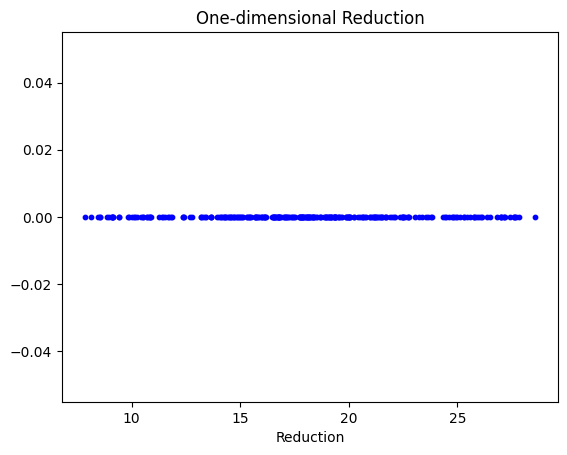

In [ ]:
sim = Mapper()

data_reduction = sim.general_reduction(X, "x[0]")

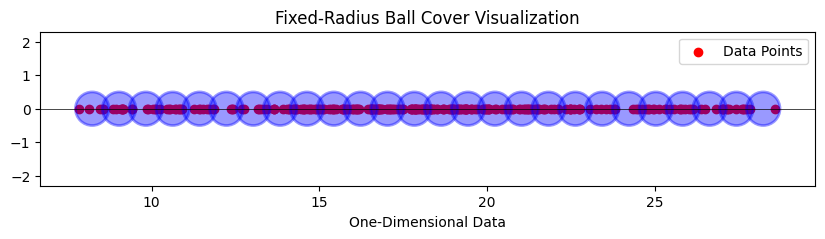

In [ ]:
covers = sim.Ball_covers(data_reduction[:, 3], radius = 0.5, g = 0.2)

In [ ]:
l = sim.split_cover(X, covers)

In [ ]:
dbscan_result = sim.apply_dbscan_to_sublists(l, epsilon = 0.25, min_samples = 5)

In [ ]:
sim.create_simplex(l, dbscan_result)

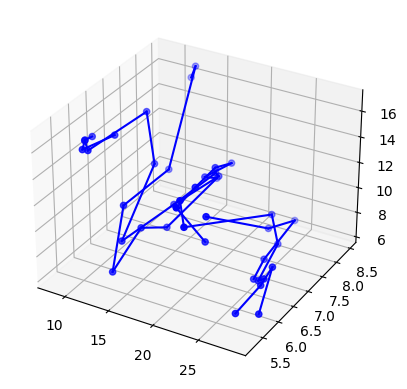

In [ ]:
sim.visualize_graph(3)

### Persistent algoritmh

simplexing
ordering
reduction
persistence
plotting


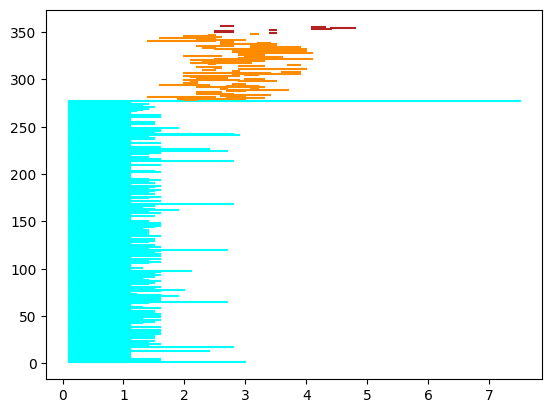

In [ ]:
filt = filtration(dimension = 3, data = X)
filt.compute_distance_matrix()
values = [0.1*i for i in range(1,51)]
filt.simply_add_value_index(values)
print("simplexing")
filt.add_simplexex_Vietoris()
print("ordering")
filt.create_basis()
filt.create_boundary_matrix()
print("reduction")
filt.compute_reduction()
print("persistence")
filt.compute_persistence()
print("plotting")
filt.see_barcode()

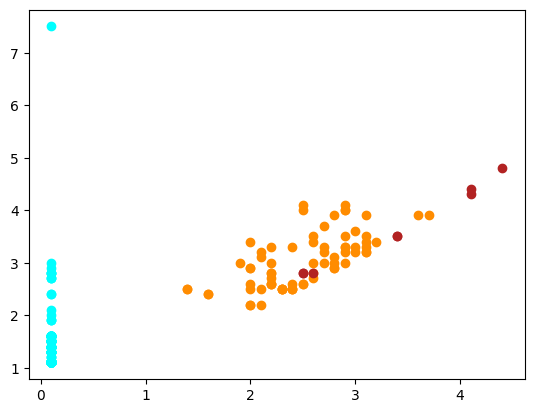

In [ ]:
filt.see_birth_death()